# Comparing profiles in the model vs. at the mooring *over time*

Rowan Brown | 07.04.2025

This notebook is for comparing profiles at the mooring and in the model (at various locations). There are two goals:
 1. Find dhere in the model could the mooring have been located relative to its plume
 2. Iteratively determine how long and with what magnitude the model should be forced

I will answer these questions using profiles. 

Some extra considerations:
 * How long should my EGU run be?
 * Resolution and mixing scheme? 
 * How to apply the cyclical forcing properly?

In [1]:
# Some imports
import numpy as np
import pandas as pd
import xmitgcm
import matplotlib.pylab as plt
import matplotlib as mpl
import xmitgcm.file_utils
import xmitgcm.utils
from MITgcmutils import density
import xarray as xr
import gsw
import basic_model_anayses as bma
from datetime import datetime

import sys
sys.path.insert(1, '../obs_analyses/')
import mooring_analyses
import woa_analyses

from mpl_toolkits import axisartist
from mpl_toolkits.axes_grid1 import host_subplot

## Model figures/calculations etc.

In [8]:
# Open the model data
#run = '../../../work/projects/p_so-clim/GCM_data/RowanMITgcm/mrb_034/'
run = '../MITgcm/so_plumes/mrb_038/'
ds_model = bma.open_mitgcm_output_all_vars(run)

# Adding density as a variable
ds_model = bma.calculate_sigma0_TEOS10(ds_model)

You need to test if you can use gsw in this way, feeding it ds and da etc


/tmp/ipykernel_2308948/2118324233.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


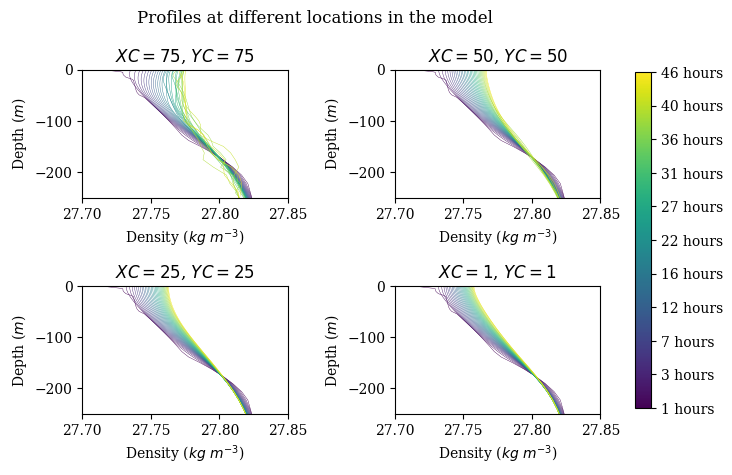

In [27]:
# Plotting /model/

# Slicing/aliasing (if it's already several hundred steps long; clunky but works)
ds = ds_model
if len(ds['time'].data)>250: ds = ds.isel(time = slice(0,-1,15) )

# Init figure
plt.rcParams["font.family"] = "serif" # change the base font
fig, ax = plt.subplots(nrows=2,ncols=2) 
plt.suptitle('Profiles at different locations in the model')

# Plotting in a loop
norm = plt.Normalize(0, len(ds['time'].data)) # Mapping time to the colourbar internal [0, 1] 
cmap = plt.cm.viridis # "viridis" is a nice colourmap that isn't, usually, a problem for people with colourblindness
for n, t in enumerate(ds['time'].data): # Looping through each date...
    c = cmap(norm(n)) # Obtaining the colour 
    ds['rho_theta'].isel(time=n,XC=75,YC=75).plot(y='Z', ax=ax[0,0], color=c, lw=0.3)
ax[0,0].set_xlabel('Density ($kg$ $m^{-3}$)')
ax[0,0].set_ylabel('Depth ($m$)')
ax[0,0].set_title('$XC=75$, $YC=75$')
ax[0,0].set_xlim(27.7,27.85)
ax[0,0].set_ylim(-250,0)

# The following is almost directly from Copilot, and it handles the colourbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
tick_locs = np.linspace(0, len(ds['time'].data), len(ds['time'].data[::round(len(ds['time'].data)/10)]))
cbar.set_ticks(tick_locs)
cbar.set_ticklabels([ str(ds['time'].data[abs(int(tick-1))].astype('timedelta64[h]')) for tick in tick_locs])

# Other plots
for n, t in enumerate(ds['time'].data): # Looping through each date...
    c = cmap(norm(n)) # Obtaining the colour 
    ds['rho_theta'].isel(time=n,XC=50,YC=50).plot(y='Z', ax=ax[0,1], color=c, lw=0.3)
ax[0,1].set_xlabel('Density ($kg$ $m^{-3}$)')
ax[0,1].set_ylabel('Depth ($m$)')
ax[0,1].set_title('$XC=50$, $YC=50$')
ax[0,1].set_xlim(27.7,27.85)
ax[0,1].set_ylim(-250,0)

for n, t in enumerate(ds['time'].data): # Looping through each date...
    c = cmap(norm(n)) # Obtaining the colour 
    ds['rho_theta'].isel(time=n,XC=25,YC=25).plot(y='Z', ax=ax[1,0], color=c, lw=0.3)
ax[1,0].set_xlabel('Density ($kg$ $m^{-3}$)')
ax[1,0].set_ylabel('Depth ($m$)')
ax[1,0].set_title('$XC=25$, $YC=25$')
ax[1,0].set_xlim(27.7,27.85)
ax[1,0].set_ylim(-250,0)

for n, t in enumerate(ds['time'].data): # Looping through each date...
    c = cmap(norm(n)) # Obtaining the colour 
    ds['rho_theta'].isel(time=n,XC=1,YC=1).plot(y='Z', ax=ax[1,1], color=c, lw=0.3)
ax[1,1].set_xlabel('Density ($kg$ $m^{-3}$)')
ax[1,1].set_ylabel('Depth ($m$)')
ax[1,1].set_title('$XC=1$, $YC=1$')
ax[1,1].set_xlim(27.7,27.85)
ax[1,1].set_ylim(-250,0)

plt.tight_layout()


/tmp/ipykernel_2308948/4107300521.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


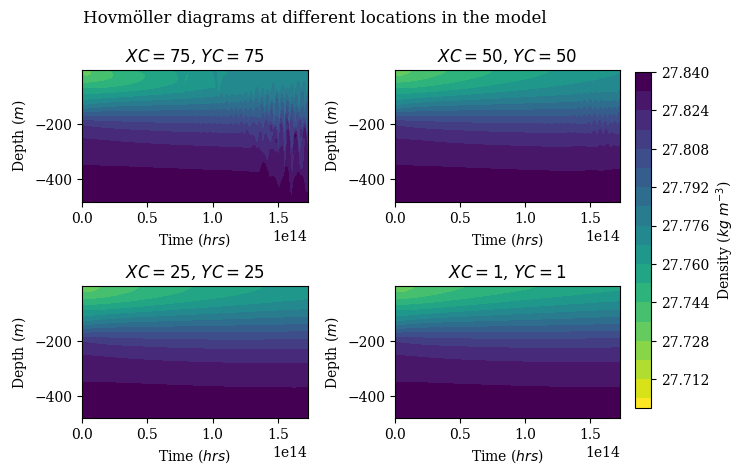

In [28]:
# Repeating plots above but with hovmoller diagrams 

ds = ds_model

# Init figure
plt.rcParams["font.family"] = "serif" # change the base font
fig, ax = plt.subplots(nrows=2,ncols=2) 
plt.suptitle('Hovmöller diagrams at different locations in the model')

norm = plt.Normalize(27.70, 27.84) # Mapping time to the colourbar internal [0, 1] 

# Plotting 4 subplots
p1 = ds['rho_theta'].isel(XC=75,YC=75).plot.contourf('time','Z',ax=ax[0,0],levels=20,cmap = plt.cm.viridis_r, norm=norm,add_colorbar=False)
ax[0,0].set_xlabel('Time ($hrs$)')
ax[0,0].set_ylabel('Depth ($m$)')
ax[0,0].set_title('$XC=75$, $YC=75$')
#ax[0,0].set_ylim(-220,-50)
p1 = ds['rho_theta'].isel(XC=50,YC=50).plot.contourf('time','Z',ax=ax[0,1],levels=20,cmap = plt.cm.viridis_r, norm=norm,add_colorbar=False)
ax[0,1].set_xlabel('Time ($hrs$)')
ax[0,1].set_ylabel('Depth ($m$)')
ax[0,1].set_title('$XC=50$, $YC=50$')
#ax[0,1].set_ylim(-220,-50)
p1 = ds['rho_theta'].isel(XC=25,YC=25).plot.contourf('time','Z',ax=ax[1,0],levels=20,cmap = plt.cm.viridis_r, norm=norm,add_colorbar=False)
ax[1,0].set_xlabel('Time ($hrs$)')
ax[1,0].set_ylabel('Depth ($m$)')
ax[1,0].set_title('$XC=25$, $YC=25$')
#ax[1,0].set_ylim(-220,-50)
p1 = ds['rho_theta'].isel(XC=1,YC=1).plot.contourf('time','Z',ax=ax[1,1],levels=20,cmap = plt.cm.viridis_r, norm=norm,add_colorbar=False)
ax[1,1].set_xlabel('Time ($hrs$)')
ax[1,1].set_ylabel('Depth ($m$)')
ax[1,1].set_title('$XC=1$, $YC=1$')
#ax[1,1].set_ylim(-220,-50)

# Handling the colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cbar = plt.colorbar(p1, cax=cbar_ax, orientation="vertical", label='Density ($kg$ $m^{-3}$)')
cbar_ax.set_ylim(27.70, 27.84)

plt.tight_layout()
plt.savefig('hovmoller_diagrams_at_different_locations_in_the_model_038.png',dpi=1200)

## Mooring figures

In [6]:
# Open the mooring data
ds_mooring = mooring_analyses.open_mooring_ml_data(time_delta='hour')
ds_mooring = mooring_analyses.correct_mooring_salinities(ds_mooring)

/albedo/home/robrow001/model_analyses/../obs_analyses/mooring_analyses.py:78: RuntimeWarning: invalid value encountered in scalar divide
  new_df['var'] = df.resample('h').apply(lambda df : np.sum(df['weights']*df['var'])/np.sum(df['weights']))
/albedo/home/robrow001/model_analyses/../obs_analyses/mooring_analyses.py:78: RuntimeWarning: invalid value encountered in scalar divide
  new_df['var'] = df.resample('h').apply(lambda df : np.sum(df['weights']*df['var'])/np.sum(df['weights']))
/albedo/home/robrow001/model_analyses/../obs_analyses/mooring_analyses.py:78: RuntimeWarning: invalid value encountered in scalar divide
  new_df['var'] = df.resample('h').apply(lambda df : np.sum(df['weights']*df['var'])/np.sum(df['weights']))


Mooring data opened
 50 m 12-month mean from mooring: 34.369026301369864
 50 m 12-month mean from WOA:     34.38139177087235
Difference: -0.012365469502483961

135 m 12-month mean from mooring: 34.62639991010118
135 m 12-month mean from WOA:     34.61529681898143
Difference: 0.011103091119750275

220 m 12-month mean from mooring: 34.65630465643637
220 m 12-month mean from WOA:     34.69025839191593
Difference: -0.03395373547956382
Salinities corrected


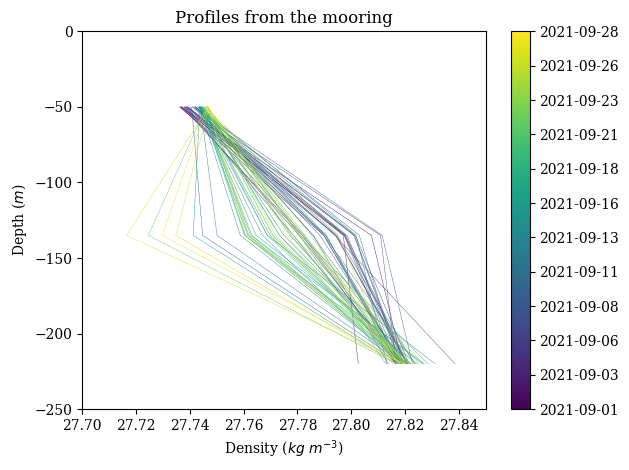

In [7]:
# Plotting the mooring data as profiles

# Init figure
plt.rcParams["font.family"] = "serif" # change the base font
fig, ax = plt.subplots()
ax.set_xlim(27.7,27.85)
ax.set_ylim(-250,0)

# Plotting in a loop
ds_mooring_short = ds_mooring.sel(day=slice(datetime(2021,9,1),datetime(2021,9,30))).isel(day=slice(0,-1,10))
ds_mooring_short = ds_mooring_short.sel(depth=[-50,-135,-220]) # Can comment out if looking at temperature
times = ds_mooring_short['day'].to_numpy()
norm = plt.Normalize(0, len(times)) # Mapping time to the colourbar internal [0, 1] 
cmap = plt.cm.viridis # "viridis" is a nice colourmap that isn't, usually, a problem for people with colourblindness
for n, t in enumerate(times): # Looping through each date...
    c = cmap(norm(n)) # Obtaining the colour 
    ds_mooring_short['pot_rho'].isel(day=n).plot(y='depth', ax=ax, color=c, lw=0.3)
ax.set_xlabel('Density ($kg$ $m^{-3}$)')
ax.set_ylabel('Depth ($m$)')
ax.set_title('Profiles from the mooring')

# The following is almost directly from Copilot, and it handles the colourbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
cbar = plt.colorbar(sm, ax=ax)
tick_locs = np.linspace(0, len(times), len(times[::6]))
cbar.set_ticks(tick_locs)
cbar.set_ticklabels([str(tick)[:10] for tick in times[::6]])

plt.tight_layout()

(27.7, 27.84)

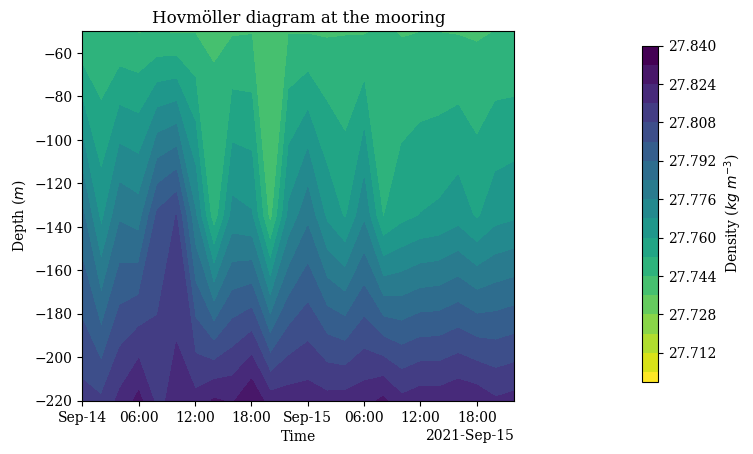

In [8]:
# Plotting the mooring data as a Hovmoller

# Init figure
plt.rcParams["font.family"] = "serif" # change the base font
fig, ax = plt.subplots() 

norm = plt.Normalize(27.70, 27.84) # Mapping time to the colourbar internal [0, 1] 

ds_mooring_short = ds_mooring.sel(day=slice(datetime(2021,9,14),datetime(2021,9,16))).isel(day=slice(0,-1,2))
ds_mooring_short = ds_mooring_short.sel(depth=[-50,-135,-220]) # Can comment out if looking at temperature
p1 = ds_mooring_short['pot_rho'].plot.contourf('day','depth',ax=ax,levels=20,cmap = plt.cm.viridis_r, norm=norm, add_colorbar=False)
ax.set_xlabel('Time')
ax.set_ylabel('Depth ($m$)')
ax.set_title('Hovmöller diagram at the mooring')
ax.set_ylim(-220,-50)

# Handling the colourbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cbar = plt.colorbar(p1, cax=cbar_ax, orientation="vertical", label='Density ($kg$ $m^{-3}$)')
cbar_ax.set_ylim(27.70, 27.84)